In [1]:
from matplotlib.patches import Rectangle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
#Matrix A: stays
descriptive_df = pd.read_excel('DAILY RATE WORKBOOK.xlsx',sheet_name='giratecheck_33481661')
subset_descriptive = descriptive_df.iloc[:,[2,3,5,6,10,14]]
df_cleaned = subset_descriptive.dropna(how='all')
df_cleaned = df_cleaned.drop(index=[1,1693,1694], inplace=False)
df_cleaned.reset_index(inplace=True)
df_cleaned = df_cleaned.iloc[:,1:]
df_cleaned = df_cleaned.loc[df_cleaned['DEPARTURE DATE'] < '07-01-25']

In [5]:
# 3. Aggregate to create a Unified Demand Matrix (6x30)
# First, create helper columns for calculations
df_cleaned['is_checkout'] = df_cleaned['RESV_STATUS'] == 'CKOT'
df_cleaned['is_cancel'] = df_cleaned['RESV_STATUS'] == 'CXL'
df_cleaned['is_noshow'] = df_cleaned['RESV_STATUS'] == 'NOSH'
df_cleaned['stay_price'] = df_cleaned['DAILY RATE'] * df_cleaned['LENGTH OF STAY']

# A better approach is to calculate these metrics separately
checkout_data = df_cleaned[df_cleaned['RESV_STATUS'] == 'CKOT'].groupby(['ROOM_CATEGORY','DEPARTURE DATE'])['stay_price'].mean().reset_index(name='avg_stay_price')
cancel_data = df_cleaned[df_cleaned['RESV_STATUS'] == 'CXL'].groupby(['ROOM_CATEGORY','DEPARTURE DATE'])['DAILY RATE'].mean().reset_index(name='avg_cancel_price')
noshow_data = df_cleaned[df_cleaned['RESV_STATUS'] == 'NOSH'].groupby(['ROOM_CATEGORY','DEPARTURE DATE'])['DAILY RATE'].mean().reset_index(name='avg_noshow_price')

# Basic aggregation for counts
basic_agg = df_cleaned.groupby(['ROOM_CATEGORY','DEPARTURE DATE']).agg(
    actual_stays=('LENGTH OF STAY', 'sum'),
    cancellations=('is_cancel', 'sum'),
    no_shows=('is_noshow', 'sum')
).reset_index()

# Merge all the dataframes
demand_summary = basic_agg.merge(checkout_data, on=['ROOM_CATEGORY','DEPARTURE DATE'], how='left')
demand_summary = demand_summary.merge(cancel_data, on=['ROOM_CATEGORY','DEPARTURE DATE'], how='left')
demand_summary = demand_summary.merge(noshow_data, on=['ROOM_CATEGORY','DEPARTURE DATE'], how='left')

print(demand_summary)
# 4. Handle NaNs and Calculate Total Intent
demand_summary.fillna(0, inplace=True)
demand_summary['total_intent'] = demand_summary['actual_stays'] + demand_summary['cancellations']

# 5. Precision Forecast Logic (Log-Log)
# We use the 'Total Intent' as our Demand variable (Q)
# and the actual stay price as our Price variable (P)
demand_summary['log_p'] = np.log(demand_summary['avg_stay_price'].replace(0, np.nan))
demand_summary['log_q'] = np.log(demand_summary['total_intent'].replace(0, np.nan))

print(f"Aggregated rows (aligned by Room/Day): {len(demand_summary)}")
print(demand_summary)

    ROOM_CATEGORY DEPARTURE DATE actual_stays  cancellations  no_shows  \
0           KDA3K       06-06-25            1              0         0   
1           KDA3K       06-07-25            1              0         0   
2           KDA3K       06-08-25            3              0         0   
3           KDA3K       06-15-25            1              0         0   
4           KDA3K       06-17-25            2              0         0   
..            ...            ...          ...            ...       ...   
236         KSX5K       06-12-25            2              0         0   
237         KSX5K       06-18-25            1              0         0   
238         KSX5K       06-20-25            1              0         0   
239         KSX5K       06-22-25            1              0         0   
240         KSX5K       06-29-25            1              1         0   

    avg_stay_price avg_cancel_price avg_noshow_price  
0           198.36              NaN              NaN  
1

C:\Users\cabla\AppData\Local\Temp\ipykernel_22744\3592606212.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  demand_summary.fillna(0, inplace=True)


In [7]:
# Define room capacities (replace these values with your actual capacities)
room_assignments = pd.read_excel('TypeAssignments.xlsx')
room_assignments.columns = ['Room','Type']
room_cap = room_assignments.groupby('Type').size().reset_index(name='room_count')

room_names = {
    'KNX4QQ' : 'Standard 2 Queen', 
    'KNX2D' : 'Standard Double',
    'KNX2K' : 'Standard King',
    'KDX3K' : 'Deluxe King',
    'KSX4Q' : 'Parlor Suite',
    'KNA2Q' : 'Queen Accessible',
    'KDX3KX' :'Deluxe King Extender',
    'KDX4QQ': 'Deluxe 2 Queen',
    'KSP4K' : 'Large Porch Suite',
    'KSP3K' : 'Small Porch Suite',
    'KJX3K' : 'Junior Suite',
    'KDA3K' : 'King Accessible',
    'KSX5K' : 'Putnam Suite',
    'KJX4K' : 'Executive Suite'
}

room_capacities = {
    'KDA3K' : 2,
 	'KDX3K' :40,
	'KDX3KX': 4,
	'KDX4QQ': 8,
	'KJX3K' : 4,
	'KJX4K' : 4,
	'KNA2Q' : 3,
	'KNX2D' : 4,
	'KNX2K' :13,
	'KNX4QQ':28,
	'KSP3K' : 3,
	'KSP4K' : 3,
	'KSX4Q' : 6,
	'KSX5K' : 2,
}

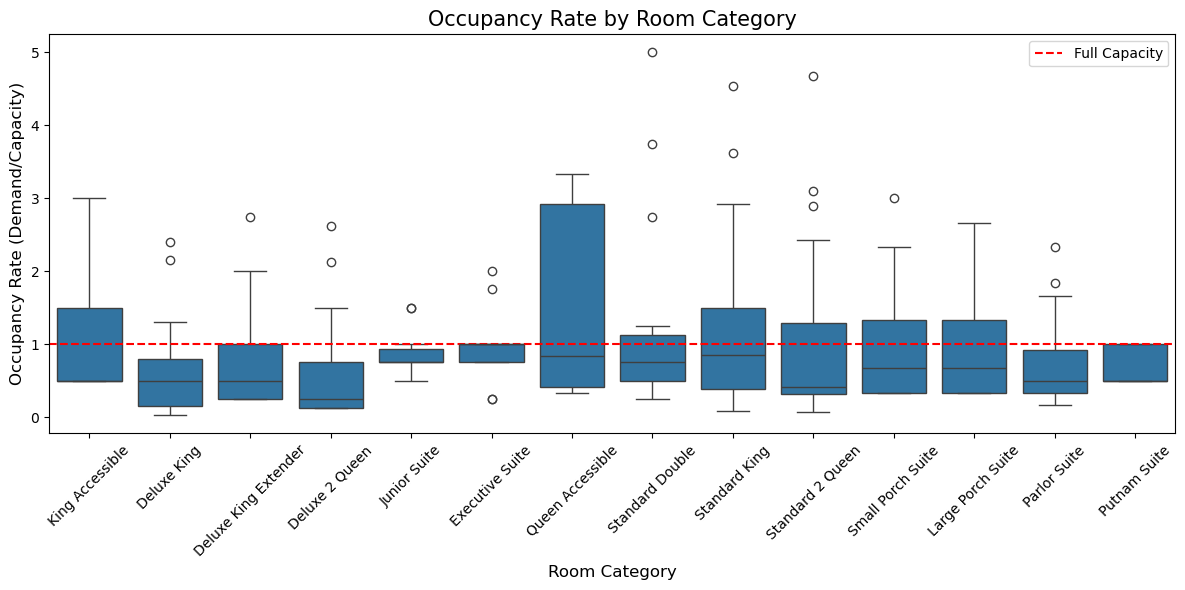

C:\Users\cabla\AppData\Local\Temp\ipykernel_22744\799449512.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  occupancy_df['DEPARTURE DATE'] = pd.to_datetime(occupancy_df['DEPARTURE DATE'])


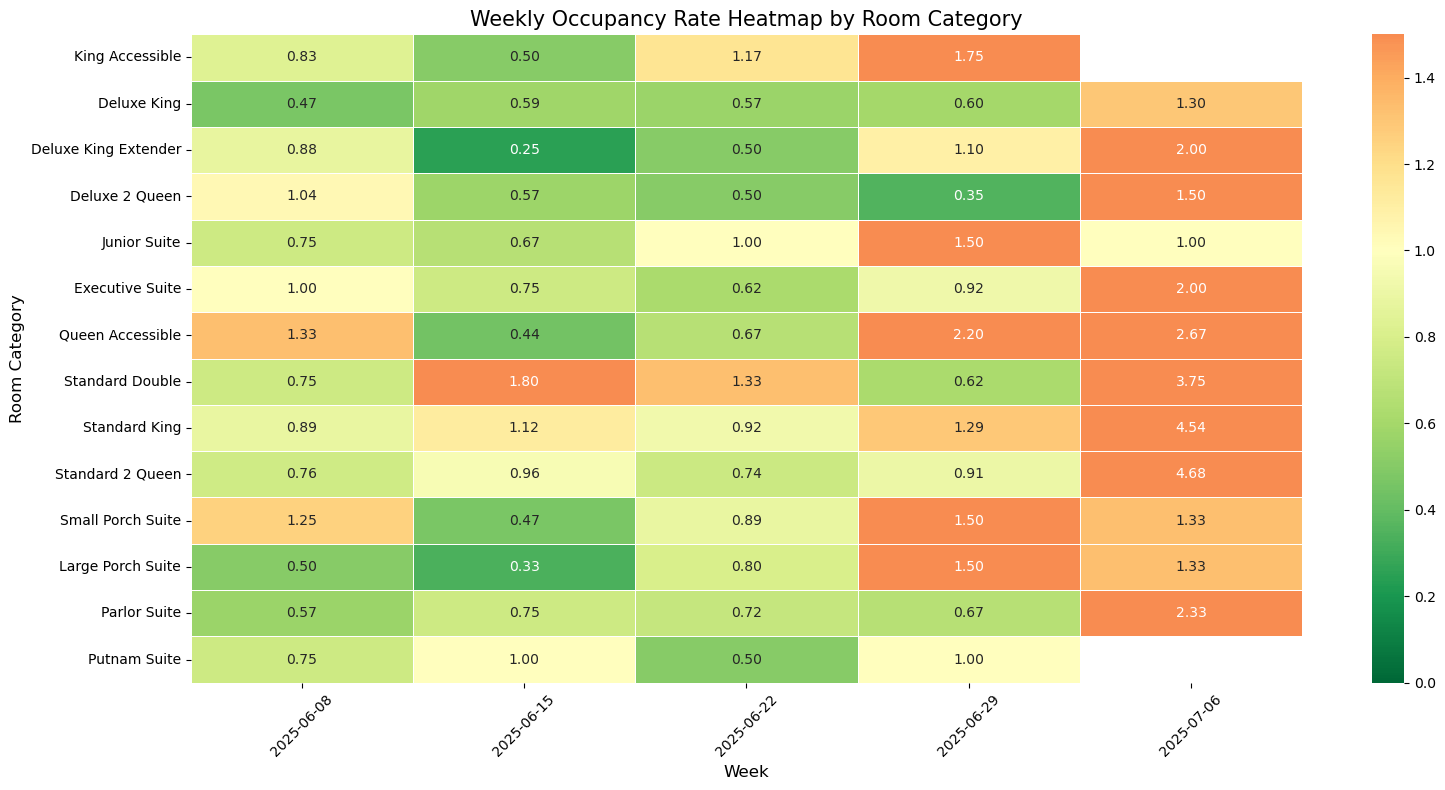

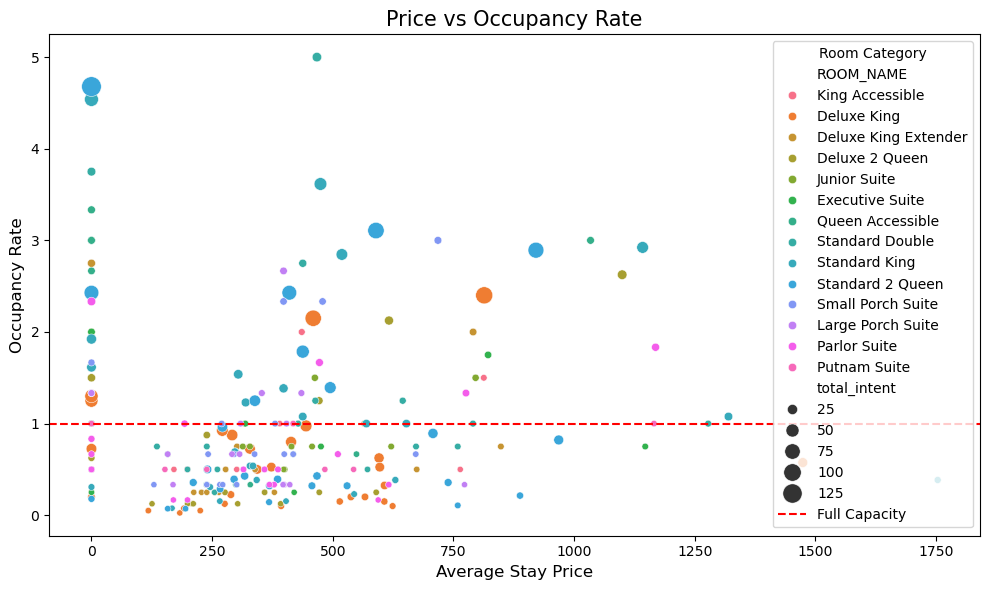

In [13]:
# Create a mask/series that maps room codes to room names
room_names_mask = demand_summary['ROOM_CATEGORY'].map(room_names)

# 3. Occupancy Rate Analysis (Demand as % of Capacity)
# Create a new dataframe with occupancy rates
occupancy_df = demand_summary.copy()
occupancy_df['capacity'] = occupancy_df['ROOM_CATEGORY'].map(room_capacities)
occupancy_df['occupancy_rate'] = occupancy_df['total_intent'] / occupancy_df['capacity']
# Apply the room names mask
occupancy_df['ROOM_NAME'] = room_names_mask

plt.figure(figsize=(12, 6))
sns.boxplot(x='ROOM_NAME', y='occupancy_rate', data=occupancy_df)
plt.axhline(y=1.0, color='r', linestyle='--', label='Full Capacity')
plt.title('Occupancy Rate by Room Category', fontsize=15)
plt.xlabel('Room Category', fontsize=12)
plt.ylabel('Occupancy Rate (Demand/Capacity)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# First, ensure 'DEPARTURE DATE' is converted to datetime format
occupancy_df['DEPARTURE DATE'] = pd.to_datetime(occupancy_df['DEPARTURE DATE'])

# Then create the pivot table
pivot_occupancy = occupancy_df.pivot_table(
    index='ROOM_CATEGORY', 
    columns=pd.Grouper(key='DEPARTURE DATE', freq='W'), 
    values='occupancy_rate',
    aggfunc='mean'
)

# Replace the index with room names using the room_names dictionary
pivot_occupancy.index = pivot_occupancy.index.map(room_names)

# Format the column labels to show only the date (not time)
pivot_occupancy.columns = pivot_occupancy.columns.strftime('%Y-%m-%d')

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_occupancy, cmap='RdYlGn_r', annot=True, fmt='.2f', 
            linewidths=.5, vmin=0, vmax=1.5, center=1.0)
plt.title('Weekly Occupancy Rate Heatmap by Room Category', fontsize=15)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Room Category', fontsize=12)
plt.xticks(rotation=45)  # Add rotation for better readability
plt.tight_layout()
plt.show()

# 5. Price vs Occupancy Rate Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_stay_price', y='occupancy_rate', hue='ROOM_NAME', 
                size='total_intent', sizes=(20, 200), data=occupancy_df)
plt.axhline(y=1.0, color='r', linestyle='--', label='Full Capacity')
plt.title('Price vs Occupancy Rate', fontsize=15)
plt.xlabel('Average Stay Price', fontsize=12)
plt.ylabel('Occupancy Rate', fontsize=12)
plt.legend(title='Room Category')
plt.tight_layout()
plt.show()

In [39]:
demand_summary

,ROOM_CATEGORY,DEPARTURE DATE,actual_stays,cancellations,no_shows,avg_stay_price,avg_cancel_price,avg_noshow_price,total_intent,log_p,log_q
0,KDA3K,06-06-25,1,0,0,198.36,0.0,0,1,5.290084,0.000000
1,KDA3K,06-07-25,1,0,0,764.15,0.0,0,1,6.638764,0.000000
2,KDA3K,06-08-25,3,0,0,813.00,0.0,0,3,6.700731,1.098612
3,KDA3K,06-15-25,1,0,0,301.00,0.0,0,1,5.707110,0.000000
4,KDA3K,06-17-25,2,0,0,390.00,0.0,0,2,5.966147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...
236,KSX5K,06-12-25,2,0,0,418.00,0.0,0,2,6.035481,0.693147
237,KSX5K,06-18-25,1,0,0,239.00,0.0,0,1,5.476464,0.000000
238,KSX5K,06-20-25,1,0,0,152.23,0.0,0,1,5.025393,0.000000
239,KSX5K,06-22-25,1,0,0,483.65,0.0,0,1,6.181362,0.000000


In [25]:
# Create a demand matrix with ROOM_CATEGORY as columns, DEPARTURE DATE as rows,
# and total_intent as values
demand_matrix = demand_summary.pivot_table(
    index='DEPARTURE DATE',
    columns='ROOM_CATEGORY',
    values='total_intent',
    aggfunc='sum'  # Aggregate by summing all instances
)

# Ensure the matrix has the expected dimensions (14x30)
# If needed, we can filter or reshape the data
#if demand_matrix.shape != (14, 30):
#    print(f"Warning: Matrix shape is {demand_matrix.shape}, expected (14, 30)")

demand_matrix = demand_matrix.replace(np.nan,0)
#demand_matrix.to_excel("Demand_Matrix", index = True)
demand_matrix

ROOM_CATEGORY,KDA3K,KDX3K,KDX3KX,KDX4QQ,KJX3K,KJX4K,KNA2Q,KNX2D,KNX2K,KNX4QQ,KSP3K,KSP4K,KSX4Q,KSX5K
DEPARTURE DATE,,,,,,,,,,,,,,
06-02-25,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
06-03-25,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,4.0,2.0,0.0,1.0,0.0,0.0
06-04-25,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,9.0,1.0,0.0,2.0,0.0
06-05-25,0.0,9.0,2.0,0.0,3.0,0.0,0.0,1.0,20.0,14.0,3.0,1.0,1.0,0.0
06-06-25,1.0,13.0,0.0,2.0,0.0,0.0,0.0,5.0,2.0,12.0,2.0,3.0,2.0,0.0
06-07-25,1.0,6.0,3.0,0.0,3.0,1.0,2.0,3.0,13.0,10.0,0.0,1.0,1.0,1.0
06-08-25,3.0,96.0,8.0,21.0,3.0,7.0,9.0,4.0,38.0,81.0,9.0,0.0,11.0,2.0
06-09-25,0.0,23.0,0.0,0.0,0.0,3.0,0.0,5.0,14.0,23.0,0.0,0.0,0.0,0.0
06-10-25,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,8.0,0.0,0.0,0.0,0.0
